<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/Random_forest_Modular_Correct(Daily_New).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/anirbanghoshsbi/pandas-technical-indicators.git

Cloning into 'pandas-technical-indicators'...
remote: Enumerating objects: 202, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (175/175), done.
remote: Total 202 (delta 105), reused 0 (delta 0), pack-reused 27
Receiving objects: 100% (202/202), 58.64 KiB | 6.52 MiB/s, done.
Resolving deltas: 100% (117/117), done.


In [2]:
!pwd

/content


In [3]:
%cd pandas-technical-indicators

/content/pandas-technical-indicators


In [4]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 4.2 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=99e58c80bb76a26e9a2d0137f98e9e1b22fb81517ef0b3bc0e249c508f2e563a
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [5]:
# Import libraries
import os
import sys
import requests
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [6]:
import technical_indicators as ta
import random_forest as rf
import confusionMatrix as cm
import easy_line_ploting as linplt

In [7]:
tickr ='^NSEI'   #'^NSEI' #^NSEBANK  #^cnxit #^GSPC #^YHOH714

In [8]:
df_old = pd.DataFrame()

In [9]:
df_old = yf.download(tickr,'2014-01-01','2020-05-01')

[*********************100%***********************]  1 of 1 completed


In [10]:
df_old.shape

(1543, 6)

# INPUT

In [11]:
# INPUT .........

#  ********************************* #

t=2
days_out=14


#  ********************************* #

In [12]:
def get_supertrend(high, low, close, lookback, multiplier):
    
    # ATR
    
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.ewm(lookback).mean()
    
    # H/L AVG AND BASIC UPPER & LOWER BAND
    
    hl_avg = (high + low) / 2
    upper_band = (hl_avg + multiplier * atr).dropna()
    lower_band = (hl_avg - multiplier * atr).dropna()
    
    # FINAL UPPER BAND
    final_bands = pd.DataFrame(columns = ['upper', 'lower'])
    final_bands.iloc[:,0] = [x for x in upper_band - upper_band]
    final_bands.iloc[:,1] = final_bands.iloc[:,0]
    for i in range(len(final_bands)):
        if i == 0:
            final_bands.iloc[i,0] = 0
        else:
            if (upper_band[i] < final_bands.iloc[i-1,0]) | (close[i-1] > final_bands.iloc[i-1,0]):
                final_bands.iloc[i,0] = upper_band[i]
            else:
                final_bands.iloc[i,0] = final_bands.iloc[i-1,0]
    
    # FINAL LOWER BAND
    
    for i in range(len(final_bands)):
        if i == 0:
            final_bands.iloc[i, 1] = 0
        else:
            if (lower_band[i] > final_bands.iloc[i-1,1]) | (close[i-1] < final_bands.iloc[i-1,1]):
                final_bands.iloc[i,1] = lower_band[i]
            else:
                final_bands.iloc[i,1] = final_bands.iloc[i-1,1]
    
    # SUPERTREND
    
    supertrend = pd.DataFrame(columns = [f'supertrend_{lookback}'])
    supertrend.iloc[:,0] = [x for x in final_bands['upper'] - final_bands['upper']]
    
    for i in range(len(supertrend)):
        if i == 0:
            supertrend.iloc[i, 0] = 0
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 0] and close[i] < final_bands.iloc[i, 0]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 0]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 0] and close[i] > final_bands.iloc[i, 0]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 1]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 1] and close[i] > final_bands.iloc[i, 1]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 1]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 1] and close[i] < final_bands.iloc[i, 1]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 0]
    
    supertrend = supertrend.set_index(upper_band.index)
    supertrend = supertrend.dropna()[1:]
    
    # ST UPTREND/DOWNTREND
    
    upt = []
    dt = []
    close = close.iloc[len(close) - len(supertrend):]

    for i in range(len(supertrend)):
        if close[i] > supertrend.iloc[i, 0]:
            upt.append(supertrend.iloc[i, 0])
            dt.append(np.nan)
        elif close[i] < supertrend.iloc[i, 0]:
            upt.append(np.nan)
            dt.append(supertrend.iloc[i, 0])
        else:
            upt.append(np.nan)
            dt.append(np.nan)
            
    st, upt, dt = pd.Series(supertrend.iloc[:, 0]), pd.Series(upt), pd.Series(dt)
    upt.index, dt.index = supertrend.index, supertrend.index
    
    return st, upt, dt

In [13]:
def get_indicators(data ,days_out,t=1):
    data = ta.relative_strength_index(data,days_out)
    #data=ta.exponential_moving_average(data,10*t)
    #data=ta.exponential_moving_average(data,50*t)
    data=ta.momentum(data,7*t)
    data=ta.rate_of_change(data,7*t)
    data=ta.exponential_moving_average(data,7*t)
    
    #data=ta.exponential_moving_average(data , 13*t)
    #data=ta.exponential_moving_average(data ,26*t)
    data=ta.force_index(data ,days_out)
    data = ta.on_balance_volume(data , days_out)
    data = ta.standard_deviation(data , days_out)
    data = ta.stochastic_oscillator_d(data ,days_out)
    data = ta.stochastic_oscillator_k(data)
    data = ta.macd(data , 9 , 12)
    data = ta.ppsr(data)
    data = ta.trix(data,days_out)
    data = ta.vortex_indicator(data , days_out)
    data = ta.find_window_high_low(data,days_out)
    #data = ta.keltner_channel(data , 13)
    #data['change_in_price'] = data['Close'].diff()
    
    return data


# Check This For Weekly or Daily 

In [14]:
############################ Comment or Uncomment Based on Daily or Weekly ##########

#df_old=df_old.resample('W').last()

In [15]:
train=int(len(df_old)*.75)
df_train= df_old[:train]
df_test= df_old[train+50:]

In [16]:
df_train.shape , df_test.shape

((1157, 6), (336, 6))

In [17]:
df_train = get_indicators(df_train,days_out,1)
df_test= get_indicators(df_test,days_out,1)

In [18]:
df_old.tail(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-29,9408.599609,9599.849609,9392.349609,9553.349609,9553.349609,653000
2020-04-30,9753.500000,9889.049805,9731.500000,9859.900391,9859.900391,931200


In [19]:
# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
df_train['Signal_Flag'] = df_train['Close'].transform(lambda x : np.sign(x.diff(days_out)))

df_train = df_train.dropna()


In [20]:
# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
df_test['Signal_Flag'] = df_test['Close'].transform(lambda x : np.sign(x.diff(days_out)))

df_test = df_test.dropna()

In [21]:
X_train = df_train.drop(['Signal_Flag'],axis=1)
y_train = df_train['Signal_Flag']
X_test = df_test.drop(['Signal_Flag'],axis=1)
y_test = df_test['Signal_Flag']

In [22]:
############## JUST REMOVE # TO COMPUTE THE BEST PARAMETERS #######################

#rf.best_param_rf(X_train , y_train , 100)

In [23]:
'''
>>> 100 iterations
{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800], 'max_features': ['auto', 'sqrt', None, 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10, 20, 30, 40], 'min_samples_leaf': [1, 2, 7, 12, 14, 16, 20], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 37.9min finished
{'Best Score': 0.9169554134840112,
 'Best parameters': {'bootstrap': True,
  'ccp_alpha': 0.0,
  'class_weight': None,
  'criterion': 'gini',
  'max_depth': 60,
  'max_features': None,
  'max_leaf_nodes': None,
  'max_samples': None,
  'min_impurity_decrease': 0.0,
  'min_impurity_split': None,
  'min_samples_leaf': 7,
  'min_samples_split': 5,
  'min_weight_fraction_leaf': 0.0,
  'n_estimators': 200,
  'n_jobs': None,
  'oob_score': False,
  'random_state': None,
  'verbose': 0,
  'warm_start': False}}
  
>>> for n_iter=300
{'Best Score': 0.9654412531082027,
 'Best parameters': {'bootstrap': False,
  'ccp_alpha': 0.0,
  'class_weight': None,
  'criterion': 'gini',
  'max_depth': 10,
  'max_features': None,
  'max_leaf_nodes': None,
  'max_samples': None,
  'min_impurity_decrease': 0.0,
  'min_impurity_split': None,
  'min_samples_leaf': 16,
  'min_samples_split': 5,
  'min_weight_fraction_leaf': 0.0,
  'n_estimators': 1800,
  'n_jobs': None,
  'oob_score': False,
  'random_state': None,
  'verbose': 0,
  'warm_start': False}}
  '''

"\n100 iterations\n{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800], 'max_features': ['auto', 'sqrt', None, 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10, 20, 30, 40], 'min_samples_leaf': [1, 2, 7, 12, 14, 16, 20], 'bootstrap': [True, False]}\nFitting 3 folds for each of 100 candidates, totalling 300 fits\n[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.\n[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.0min\n[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 19.3min\n[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 37.9min finished\n{'Best Score': 0.9169554134840112,\n 'Best parameters': {'bootstrap': True,\n  'ccp_alpha': 0.0,\n  'class_weight': None,\n  'criterion': 'gini',\n  'max_depth': 60,\n  'max_features': None,\n  'max_leaf_nodes': None,\n  'max_samples': None,\n  'min_impurity_decrease': 0.0,\n  'min_impurity_split': None,\n  'min_samples_leaf': 7,\n  'min_sa

In [24]:
# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 200,max_depth=80,min_samples_leaf=2,max_features='auto', min_samples_split=2, criterion = "gini", bootstrap=True,random_state = 42)
# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)


In [25]:
# Print the Accuracy of our Model.
print('Correct Prediction RForest (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction RForest (%):  93.91891891891892


Accuracy: 93.91891891891892
Percision: 93.33333333333333
Recall: 95.65217391304348
Specificity: 91.85185185185185


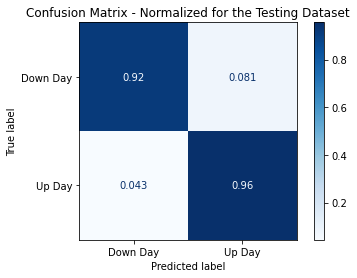

In [26]:
cm.confus_matrix(y_test,y_pred,rand_frst_clf,X_test,y_test,plot=True )

#cm.confus_matrix(actual_results , predictions,model ,<test data ( or new_data for prediction except target VAR)>, <actaul Target VAR> , <plot=True>)

In [27]:
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_imp*100
feats=X_train.columns

# Logistic Regression

In [28]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
#from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [29]:
LogReg = LogisticRegression()
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
LogReg.fit(X_train, y_train)
y_predL = LogReg.predict(X_test)

In [30]:
# Print the Accuracy of our Model.
print('Correct Prediction Logistic Regression (%): ', accuracy_score(y_test, LogReg.predict(X_test), normalize = True) * 100.0)

Correct Prediction Logistic Regression (%):  86.14864864864865


Accuracy: 86.14864864864865
Percision: 87.03703703703704
Recall: 87.5776397515528
Specificity: 84.44444444444444


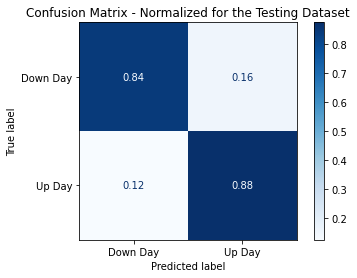

In [31]:
cm.confus_matrix(y_test,y_predL,LogReg,X_test,y_test,plot=True )

# Support Vector Classifier

In [32]:
from sklearn.svm import SVC
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
svc_classifier = SVC(kernel = 'linear', random_state = 0)
svc_classifier.fit(X_train, y_train)
y_predS = svc_classifier.predict(X_test)

In [33]:
# Print the Accuracy of our Model.
print('Correct Prediction Logistic Regression (%): ', accuracy_score(y_test, svc_classifier.predict(X_test), normalize = True) * 100.0)

Correct Prediction Logistic Regression (%):  85.8108108108108


Accuracy: 85.8108108108108
Percision: 88.38709677419355
Recall: 85.09316770186336
Specificity: 86.66666666666667


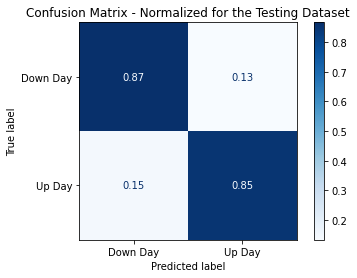

In [34]:
cm.confus_matrix(y_test,y_predS,svc_classifier,X_test,y_test,plot=True )

# XGBoost Classifier

In [35]:
import xgboost as xgb

In [36]:
'''
param_test1 = {
 'max_depth':range(3,6,2),'learning_rate':[0.001,0.01,0.1,0.05],
 'min_child_weight':range(1,4,2),'reg_alpha':[0, 0.001, 0.005, 0.01],'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,85,5)],'gamma':[i/10.0 for i in range(0,2)],
 'n_estimators': [10,50,100,200,300]
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,reg_alpha=1e-5,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,verbose=10,cv=5)
 
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_
'''

"\nparam_test1 = {\n 'max_depth':range(3,6,2),'learning_rate':[0.001,0.01,0.1,0.05],\n 'min_child_weight':range(1,4,2),'reg_alpha':[0, 0.001, 0.005, 0.01],'subsample':[i/100.0 for i in range(75,90,5)],\n 'colsample_bytree':[i/100.0 for i in range(75,85,5)],'gamma':[i/10.0 for i in range(0,2)],\n 'n_estimators': [10,50,100,200,300]\n}\ngsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,\n min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,reg_alpha=1e-5,\n objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), \n param_grid = param_test1, scoring='roc_auc',n_jobs=4,verbose=10,cv=5)\n \ngsearch1.fit(X_train,y_train)\ngsearch1.best_params_, gsearch1.best_score_\n"

In [37]:
xgb_classifier = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=200,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb_classifier.fit(X_train, y_train)
y_predX = xgb_classifier.predict(X_test)
print("Accuracy for XGBoost Model: %.2f" % (accuracy_score(y_test, y_predX) * 100))

Accuracy for XGBoost Model: 91.55


Accuracy: 91.55405405405406
Percision: 88.63636363636364
Recall: 96.8944099378882
Specificity: 85.18518518518519


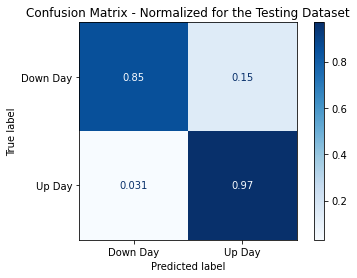

In [38]:
cm.confus_matrix(y_test,y_predX,xgb_classifier,X_test,y_test,plot=True )

In [39]:
feature_imp_XGB = pd.Series(xgb_classifier.feature_importances_, index=feats).sort_values(ascending=False)
feature_imp_XGB*100

Vortex_14                   26.610783
MACD_9_12                   24.579092
OBV_14                       6.973462
Win_High                     3.572344
MACDsign_9_12                2.640367
RSI_14                       2.330659
STD_14                       2.268503
MACDdiff_9_12                2.247545
Momentum_7                   2.171185
Trix_14                      2.115852
SO%k                         2.088415
Open                         2.000174
S1                           1.919409
Force_14                     1.829139
S2                           1.763083
EMA_7                        1.758127
Win_Low                      1.715929
High                         1.659455
SO%d_14                      1.625381
Volume                       1.325008
Low                          1.239178
Close                        1.165148
ROC_7                        1.042477
S3                           0.854259
PP                           0.652416
R3                           0.651186
R1          

In [40]:
features = {'Random Forest' : feature_imp,'XGBoost': feature_imp_XGB}
feats=pd.DataFrame(features)

In [41]:
feats.sort_values(by=['XGBoost'],ascending=False)

,Random Forest,XGBoost
Vortex_14,0.260419,0.266108
MACD_9_12,0.163476,0.245791
OBV_14,0.138220,0.069735
Win_High,0.005373,0.035723
MACDsign_9_12,0.067645,0.026404
RSI_14,0.090399,0.023307
STD_14,0.012952,0.022685
MACDdiff_9_12,0.026671,0.022475
Momentum_7,0.046167,0.021712
Trix_14,0.024032,0.021159


# Make Actual Prediction

In [42]:
df = pd.DataFrame()

In [43]:
df = yf.download(tickr,'2020-10-01')

[*********************100%***********************]  1 of 1 completed


In [44]:
df.tail(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-09-02,17095.400391,17245.500000,17059.699219,17234.150391,17234.150391,242400
2021-09-03,17262.449219,17340.099609,17212.199219,17323.599609,17323.599609,261400
2021-09-06,17399.349609,17429.550781,17349.199219,17353.099609,17353.099609,0


# Check This For Weekly or Daily

In [45]:
####################### Comment or Uncomment Based on Weekly or Daily ##################
#df=df.resample('W').last()

In [46]:
df = get_indicators(df,days_out,1)
#df= impulse(df)

In [47]:
df.tail(2)

,Open,High,Low,Close,Adj Close,Volume,RSI_14,Momentum_7,ROC_7,EMA_7,Force_14,OBV_14,STD_14,SO%d_14,SO%k,MACD_9_12,MACDsign_9_12,MACDdiff_9_12,PP,R1,S1,R2,S2,R3,S3,Trix_14,Vortex_14,Win_High,Win_Low,Signals_from_Window_HiLo
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-09-03,17262.449219,17340.099609,17212.199219,17323.599609,17323.599609,261400,0.905380,688.949219,0.041276,17049.17717,-4.806725e+07,156171.428571,292.907901,0.675568,0.870993,91.309141,70.492493,20.816648,17291.966146,17371.733073,17243.832682,17419.866536,17164.065755,17499.633464,17115.932292,0.002307,0.711081,17245.500000,16376.049805,1.0
2021-09-06,17399.349609,17429.550781,17349.199219,17353.099609,17353.099609,0,0.918135,716.199219,0.038784,17125.15778,-2.006724e+08,138028.571429,321.534289,0.591964,0.048542,94.546892,75.303373,19.243519,17377.283203,17405.367188,17325.015625,17457.634766,17296.931641,17485.718750,17244.664062,0.002437,0.737753,17340.099609,16376.049805,1.0


In [48]:
df_old.head(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,6301.250000,6358.299805,6211.299805,6221.149902,6221.149902,158100
2014-01-03,6194.549805,6221.700195,6171.250000,6211.149902,6211.149902,139000


In [49]:
# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
df['Signal_Flag'] = df['Close'].transform(lambda x : np.sign(x.diff(days_out)))

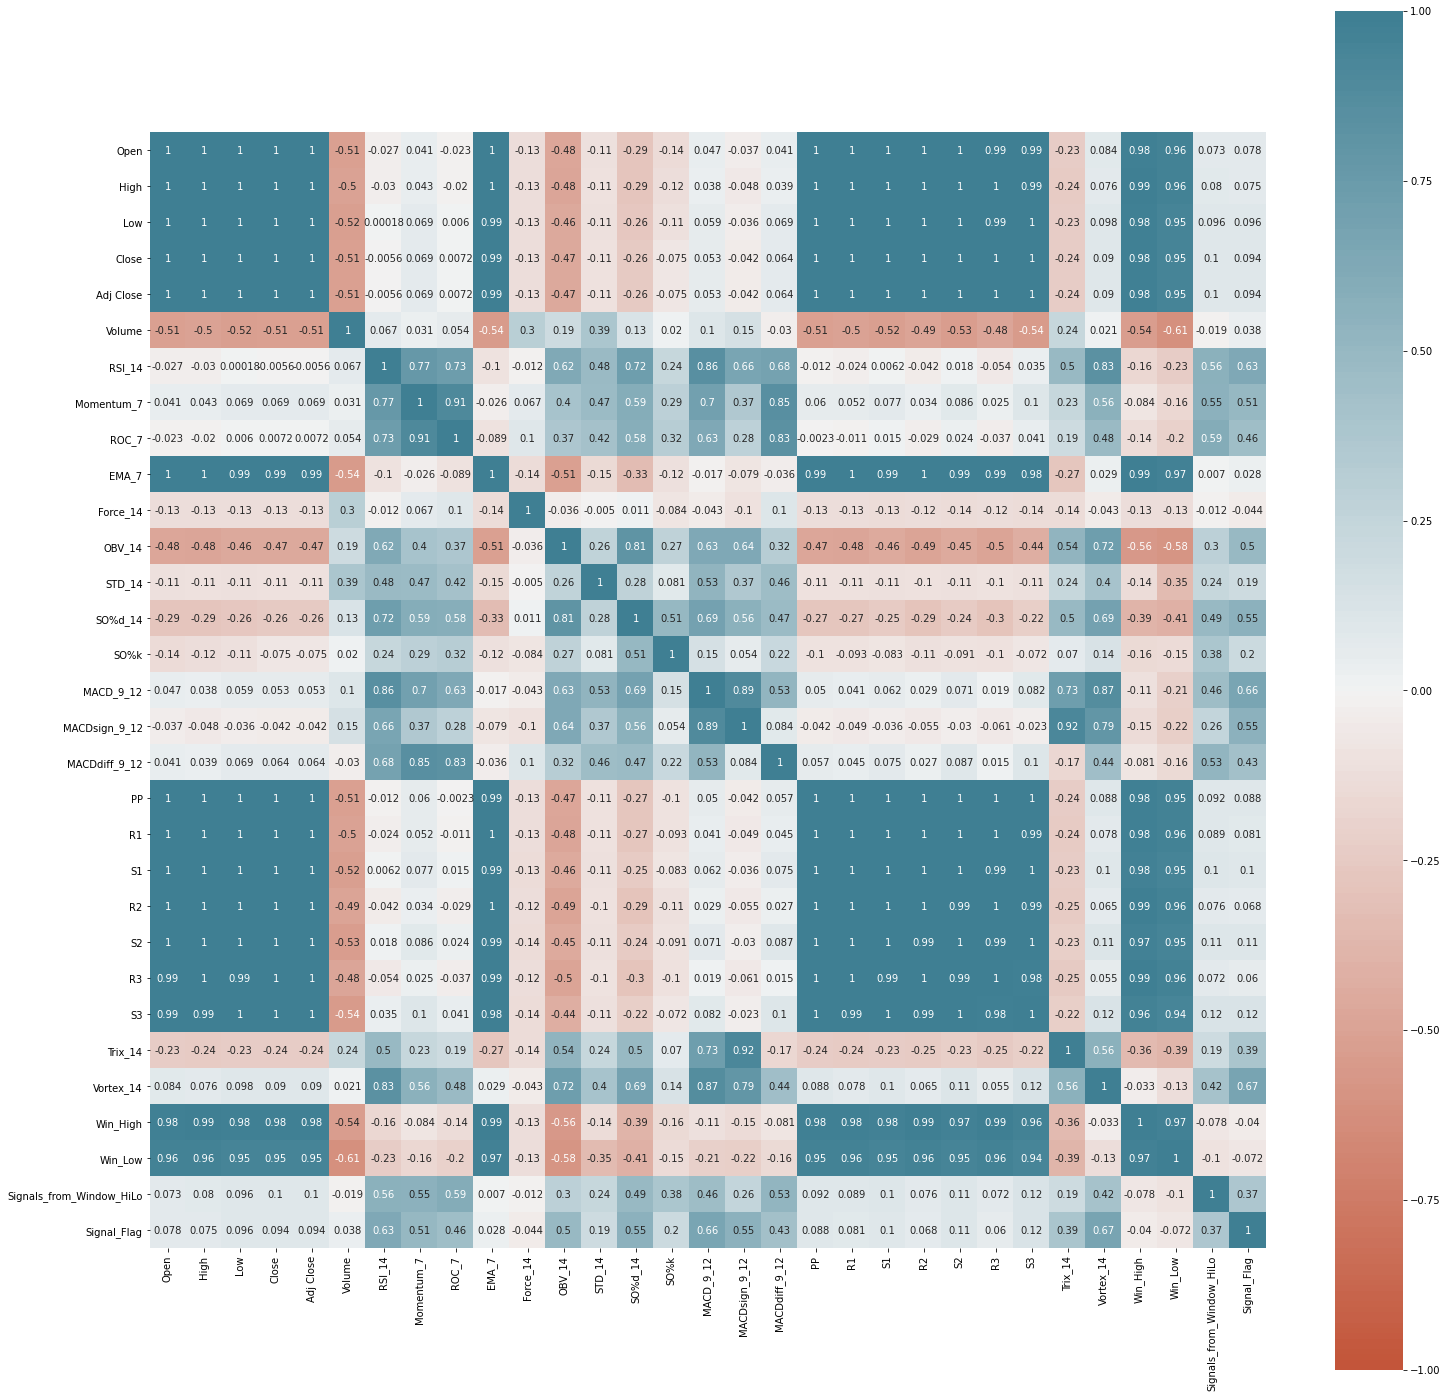

In [50]:
ta.correlation_map(df,25)

In [51]:
df.shape

(229, 31)

In [52]:
df=df.dropna()

In [53]:
df.shape

(189, 31)

In [54]:
new_data = df.drop(['Signal_Flag'],axis=1)
actuals= df['Signal_Flag']


# Make Predictions Using Random Forest

In [55]:
model='random_forest'

In [56]:
preds=rf.make_preds(new_data ,rand_frst_clf,model,df)

In [57]:
print("days_out : ",days_out)

days_out :  14


In [58]:
preds.head(2)

,predsrandom_forest
Date,
2020-12-01,1.0
2020-12-02,1.0


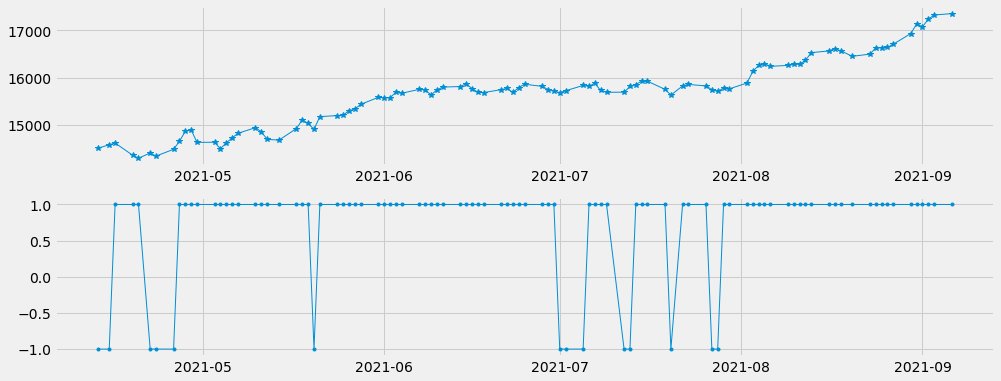

In [59]:
linplt.lineplot(2,15,6,df,preds['predsrandom_forest'], no_of_datapoints=100) # no_of_datapoints=100

In [60]:
pred = pd.DataFrame(rf.make_preds(new_data , rand_frst_clf, model,df))

In [61]:
pred.head(2)

,predsrandom_forest
Date,
2020-12-01,1.0
2020-12-02,1.0


In [62]:
pred = pd.concat([pred ,df.Close],axis=1)
#pred.columns=['Date','preds','Close']
#pred= pred.set_index('Date')

In [63]:
l= len(pred)

In [64]:
#fig, ax = plt.subplots(1,1,figsize=(20,7))
#Identifying the buy/sell zone
pred['Buy_ind'] = np.where((pred['predsrandom_forest']==1), 1, 0)
pred['Sell_ind'] = np.where((pred['predsrandom_forest']==-1), 0, 1)

In [65]:
pred=pred.reset_index()

# Make Prediction Using XGBoost

In [66]:
model='_XGB'

In [67]:
predX=rf.make_preds(new_data.values ,xgb_classifier,model,df)

In [68]:
predX= pd.concat([predX ,df.Close],axis=1)

In [69]:
predX.head(2)

,preds_XGB,Close
Date,,
2020-12-01,1.0,13109.049805
2020-12-02,1.0,13113.750000


In [70]:
#Identifying the buy/sell zone
predX['Buy_ind_XGB'] = np.where((predX['preds_XGB']==1), 1, 0)
predX['Sell_ind_XGB'] = np.where((predX['preds_XGB']==-1), 0, 1)

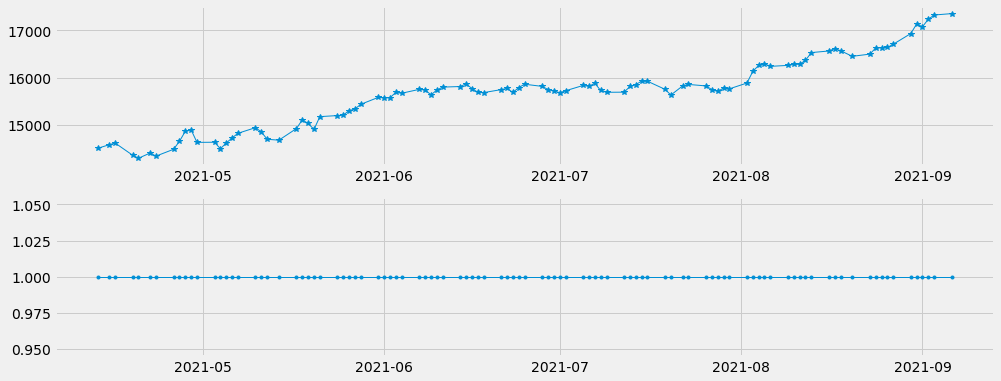

In [71]:
linplt.lineplot(2,15,6,df,predX['preds_XGB'], no_of_datapoints=100) # no_of_datapoints=100

In [72]:
predX=predX.reset_index()

# Make Prediction Using Logistics Regression

In [73]:
model='_Logistic_Regression'

In [74]:
preds_logreg=pd.DataFrame(rf.make_preds(new_data , LogReg,model, df))

In [75]:
preds_logreg.head(2)

,preds_Logistic_Regression
Date,
2020-12-01,-1.0
2020-12-02,1.0


In [76]:
predL = pd.concat([preds_logreg ,df.Close],axis=1)

In [77]:
predL=predL.reset_index()

In [78]:
#Identifying the buy/sell zone
predL['Buy_ind_Logreg'] = np.where((predL['preds_Logistic_Regression']==1), 1, 0)
predL['Sell_ind_Logreg'] = np.where((predL['preds_Logistic_Regression']==-1), 0, 1)

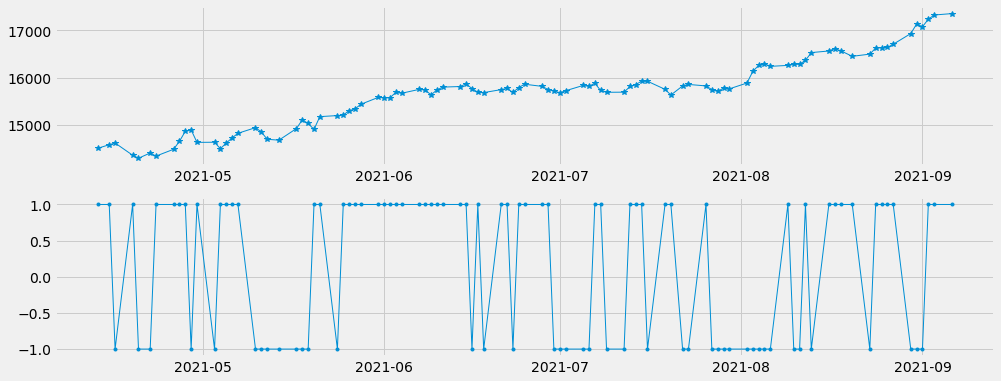

In [79]:
linplt.lineplot(2,15,6,df,preds_logreg['preds_Logistic_Regression'], no_of_datapoints=100) # no_of_datapoints=100

# Make Predictions using Support Vector Classifier

In [80]:
model='_SVC'

In [81]:
preds_svc=pd.DataFrame(rf.make_preds(new_data ,svc_classifier,model, df))

In [82]:
predS = pd.concat([preds_svc,df.Close],axis=1)

In [83]:
predS=predS.reset_index()

In [84]:
#Identifying the buy/sell zone
predS['Buy_ind_SVC'] = np.where((predS['preds_SVC']==1), 1, 0)
predS['Sell_ind_SVC'] = np.where((predS['preds_SVC']==-1), 0, 1)

# PREDICTIONS

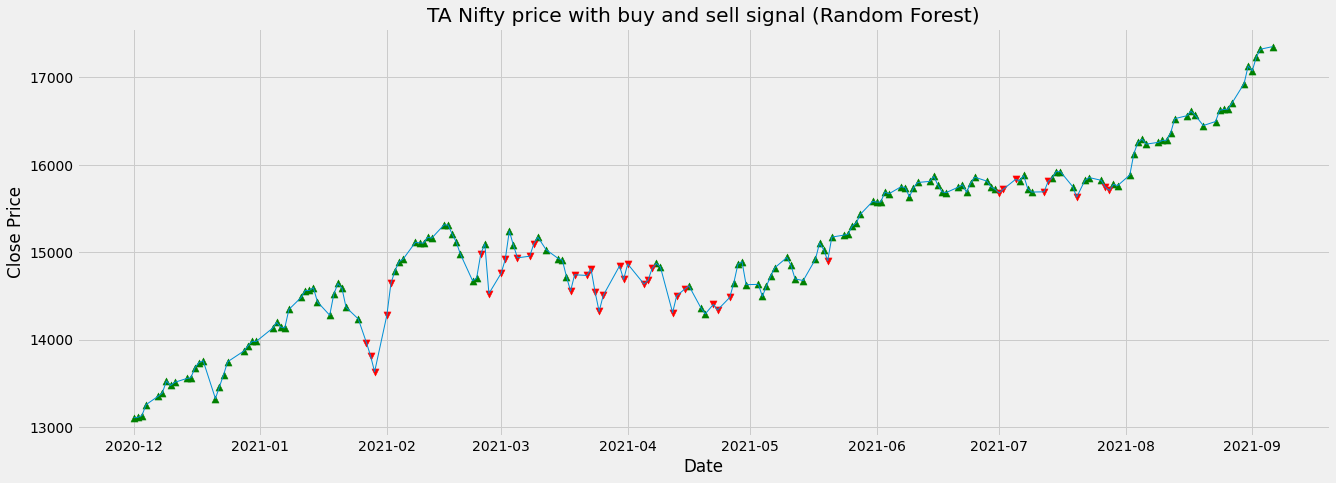

In [85]:
plt.figure(figsize=(20,7))
## plotting the buy and sell signals on graph
plt.plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=1)
plt.scatter(pred.loc[pred['Buy_ind'] ==1 , 'Date'].values,pred.loc[pred['Buy_ind'] ==1, 'Close'].values, label='skitscat', color='green', s=50, marker="^")
plt.scatter(pred.loc[pred['Sell_ind'] ==0 , 'Date'].values,pred.loc[pred['Sell_ind'] ==0, 'Close'].values, label='skitscat', color='red', s=50, marker="v")

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('TA Nifty price with buy and sell signal (Random Forest)') 

plt.savefig('a.png')
plt.show();

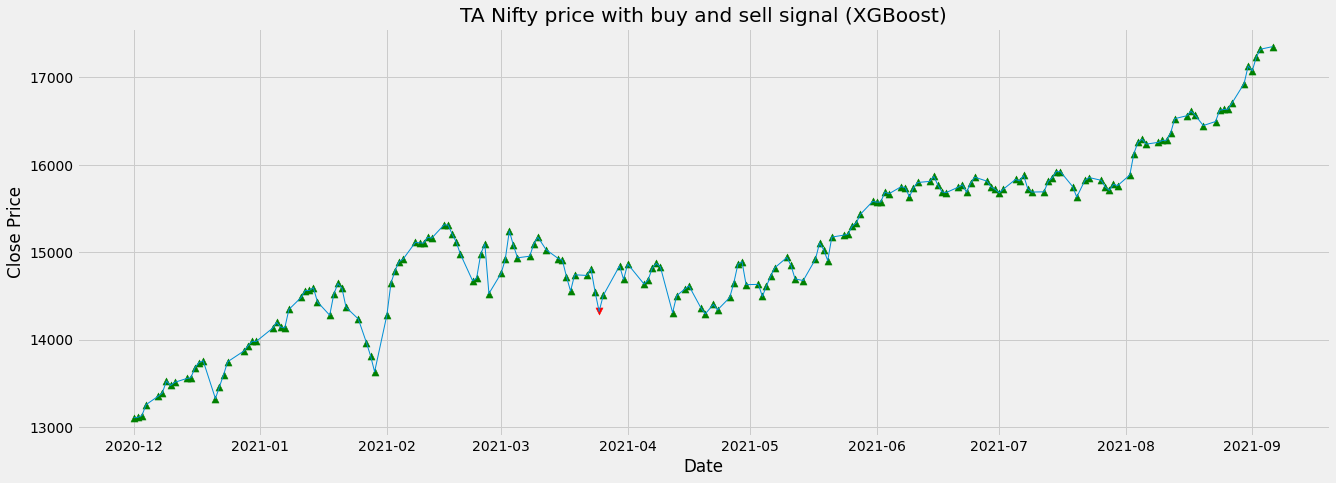

In [86]:
plt.figure(figsize=(20,7))
## plotting the buy and sell signals on graph
plt.plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=1)
plt.scatter(predX.loc[predX['Buy_ind_XGB'] ==1 , 'Date'].values,predX.loc[predX['Buy_ind_XGB'] ==1, 'Close'].values, label='skitscat', color='green', s=50, marker="^")
plt.scatter(predX.loc[predX['Sell_ind_XGB'] ==0 , 'Date'].values,predX.loc[predX['Sell_ind_XGB'] ==0, 'Close'].values, label='skitscat', color='red', s=50, marker="v")

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('TA Nifty price with buy and sell signal (XGBoost)') 

plt.savefig('a.png')
plt.show();

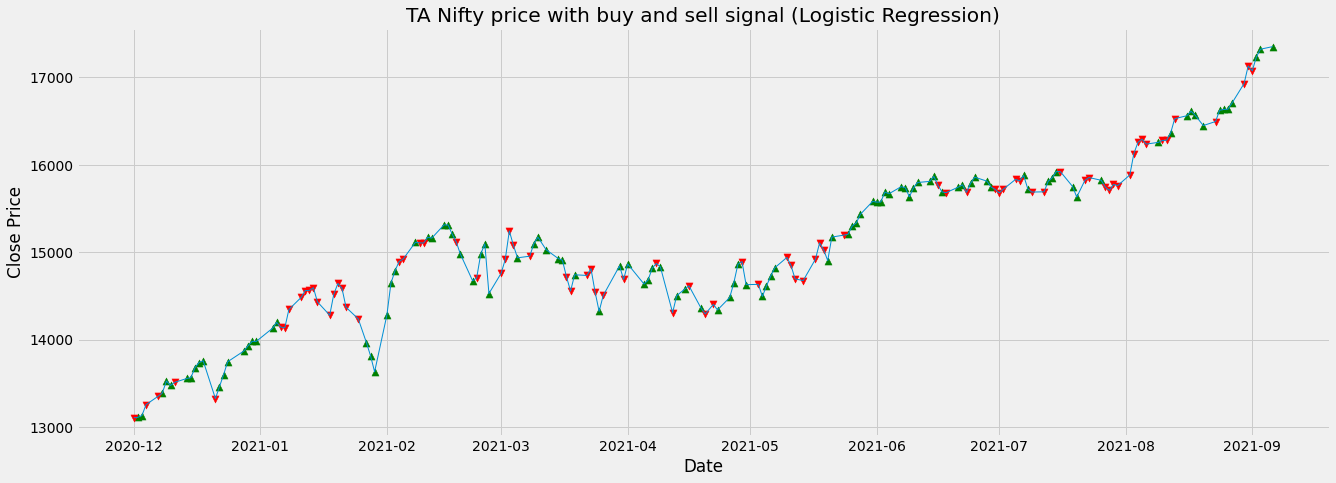

In [87]:
plt.figure(figsize=(20,7))
## plotting the buy and sell signals on graph
plt.plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=1)
plt.scatter(predL.loc[predL['Buy_ind_Logreg'] ==1 , 'Date'].values,predL.loc[predL['Buy_ind_Logreg'] ==1, 'Close'].values, label='skitscat', color='green', s=50, marker="^")
plt.scatter(predL.loc[predL['Sell_ind_Logreg'] ==0 , 'Date'].values,predL.loc[predL['Sell_ind_Logreg'] ==0, 'Close'].values, label='skitscat', color='red', s=50, marker="v")

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('TA Nifty price with buy and sell signal (Logistic Regression)') 

plt.savefig('a.png')
plt.show();

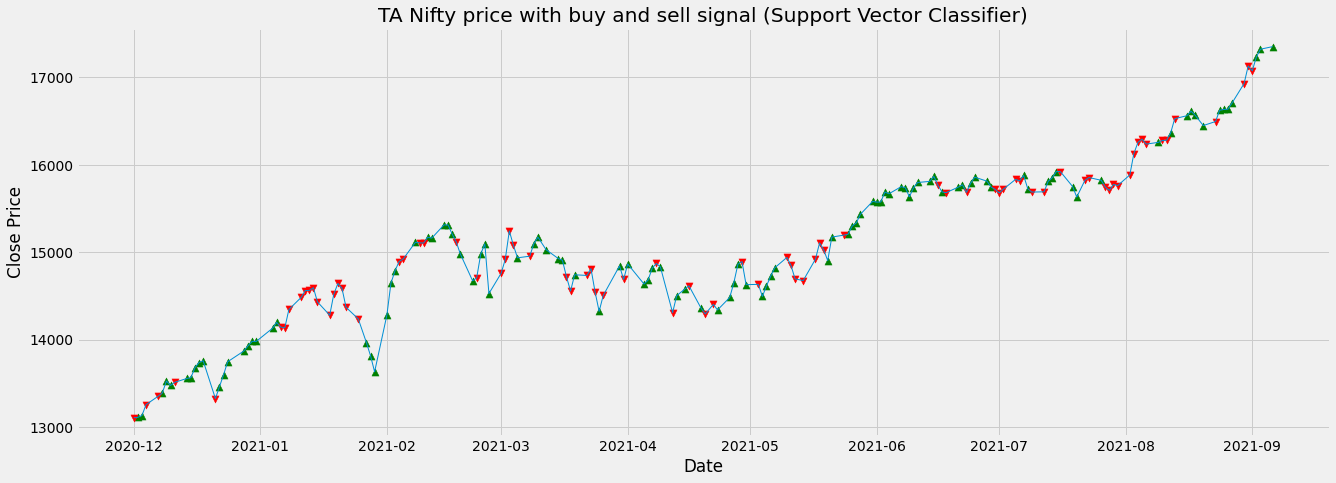

In [88]:
plt.figure(figsize=(20,7))
## plotting the buy and sell signals on graph
plt.plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=1)
plt.scatter(predS.loc[predS['Buy_ind_SVC'] ==1 , 'Date'].values,predS.loc[predS['Buy_ind_SVC'] ==1, 'Close'].values, label='skitscat', color='green', s=50, marker="^")
plt.scatter(predS.loc[predS['Sell_ind_SVC'] ==0 , 'Date'].values,predS.loc[predS['Sell_ind_SVC'] ==0, 'Close'].values, label='skitscat', color='red', s=50, marker="v")

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('TA Nifty price with buy and sell signal (Support Vector Classifier)') 

plt.savefig('a.png')
plt.show();

In [89]:
pred['ensemble'] = pred['predsrandom_forest']*1.0+predL['preds_Logistic_Regression']*0.5+predS['preds_SVC']*0.5

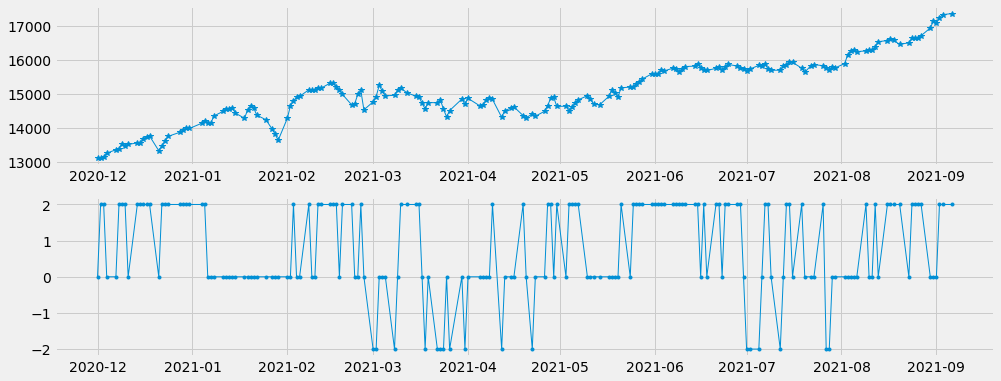

In [90]:
linplt.lineplot(2,15,6,df,pred['ensemble'], no_of_datapoints=450) # no_of_datapoints=100

In [91]:
#pred['Signal_from_close']=np.where((pred.Close>pred.Close.shift(1)),1,0)

In [92]:
#Identifying the buy/sell zone
pred['Buy_ensemble'] = np.where((pred['ensemble']>=0), 1, 0)

pred['Sell_ensemble'] = np.where((pred['ensemble']<0), 0, 1)
#pred['Neutral'] = np.where((pred['ensemble']==-0.5),0,1)
pred['signal4theday']= np.where((pred['ensemble']>=0),1,0)

In [93]:
pred['signalF']=pred['signal4theday']

In [94]:
pred.to_csv('rf_ta.csv')

In [95]:
pred[['signal4theday','signalF','Close']].tail(5)

,signal4theday,signalF,Close
184,1,1,17132.199219
185,1,1,17076.250000
186,1,1,17234.150391
187,1,1,17323.599609
188,1,1,17353.099609


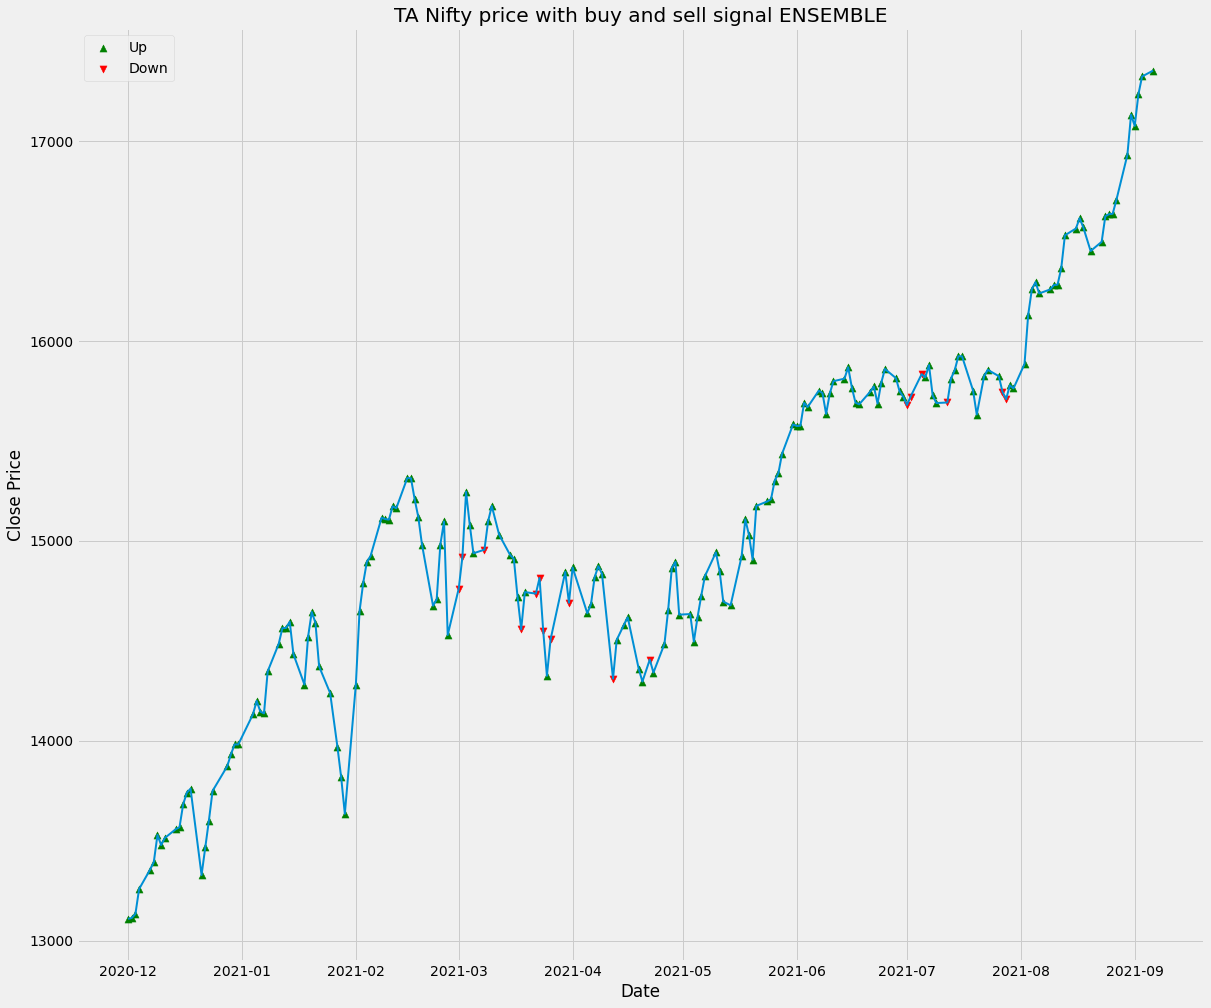

In [96]:
plt.figure(figsize=(18,16))
## plotting the buy and sell signals on graph
plt.plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=2)
plt.scatter(pred.loc[pred['Buy_ensemble'] ==1 , 'Date'].values,pred.loc[pred['Buy_ensemble'] ==1, 'Close'].values, label='Up', color='green', s=50, marker="^")
plt.scatter(pred.loc[pred['Sell_ensemble'] ==0 , 'Date'].values,pred.loc[pred['Sell_ensemble'] ==0, 'Close'].values, label='Down', color='red', s=50, marker="v")
#plt.scatter(pred.loc[pred['Neutral'] ==0 , 'Date'].values,pred.loc[pred['Neutral'] ==0, 'Close'].values, label='skitscat', color='blue', s=50, marker="*")
#plt.plot(df.index,df['EMA_50'].values[-l:],label='EMA 50')
#plt.plot(df.index,df['EMA_26'].values[-l:], label='EMA 26')

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price') 
plt.legend(loc='upper left') 
plt.title('TA Nifty price with buy and sell signal ENSEMBLE') 
plt.show();

Accuracy: 92.06349206349206
Percision: 93.28859060402685
Recall: 96.52777777777779
Specificity: 77.77777777777779


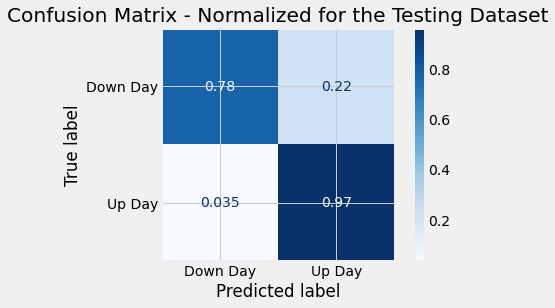

In [97]:
cm.confus_matrix(df.Signal_Flag,preds,rand_frst_clf,new_data,actuals,plot=True )


Accuracy: 93.91891891891892
Percision: 93.33333333333333
Recall: 95.65217391304348
Specificity: 91.85185185185185


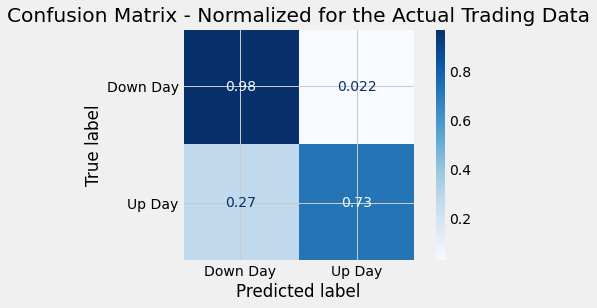

In [98]:
cm.confus_matrix(y_test,y_pred,rand_frst_clf,X_test,y_test,plot=True, test=False)


In [99]:
# saving the dataframe
pred[['Date','signalF']].to_csv('/content/rf_TA.csv')

In [100]:
pred.head(1)

,Date,predsrandom_forest,Close,Buy_ind,Sell_ind,ensemble,Buy_ensemble,Sell_ensemble,signal4theday,signalF
0,2020-12-01,1.0,13109.049805,1,1,0.0,1,1,1,1


In [101]:
pred.set_index('Date',inplace=True)

In [102]:
pred.tail(2)

,predsrandom_forest,Close,Buy_ind,Sell_ind,ensemble,Buy_ensemble,Sell_ensemble,signal4theday,signalF
Date,,,,,,,,,
2021-09-03,1.0,17323.599609,1,1,2.0,1,1,1,1
2021-09-06,1.0,17353.099609,1,1,2.0,1,1,1,1


In [103]:
pred['actual']=np.where(pred.Close>pred.Close.shift(1),1,0)
pred['dummy']= np.where(pred.signal4theday==0,0,1)
pred['dummyS']=pred['dummy'].shift(1)
pred=pred.dropna()

In [104]:
pred.signalF.value_counts()

1    171
0     17
Name: signalF, dtype: int64

In [105]:
pred.dummyS.value_counts()

1.0    171
0.0     17
Name: dummyS, dtype: int64

In [106]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

rf_matrix = confusion_matrix(pred.actual, pred.dummyS)

true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(pred.actual, pred.dummyS)

accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
percision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)
f1score= 2*recall*percision/(percision+recall)
print('Accuracy: {}'.format(float(accuracy)))
print('Percision: {}'.format(float(percision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))
print('F1-Score: {}'.format(float(f1score)))
print('Average Precision : {}'.format(float(average_precision)))

Accuracy: 0.5797872340425532
Percision: 0.6081871345029239
Recall: 0.896551724137931
Specificity: 0.06944444444444445
F1-Score: 0.7247386759581882
Average Precision : 0.6091010112711468


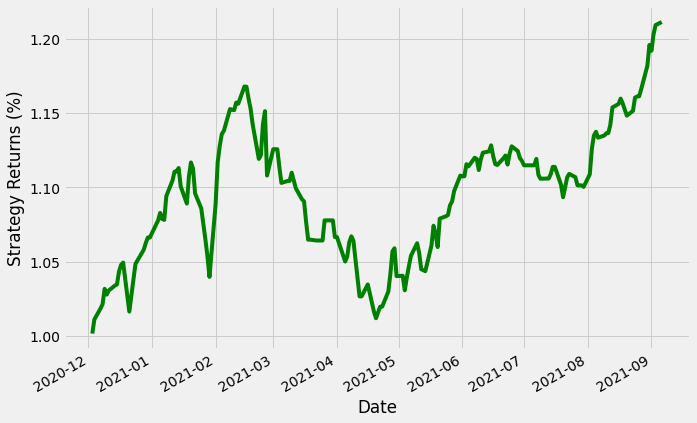

In [107]:
# Calculate daily returns
pred['Return'] = pred.Close.pct_change()

# Calculate strategy returns
pred['Strategy_Return'] = pred.Return * pred.dummy.shift(1)

# Calculate geometric returns
geometric_returns = (pred.Strategy_Return+1).cumprod()

# Plot geometric returns
geometric_returns.plot(figsize=(10, 7),color='g')
plt.ylabel("Strategy Returns (%)")
plt.xlabel("Date")
plt.show()

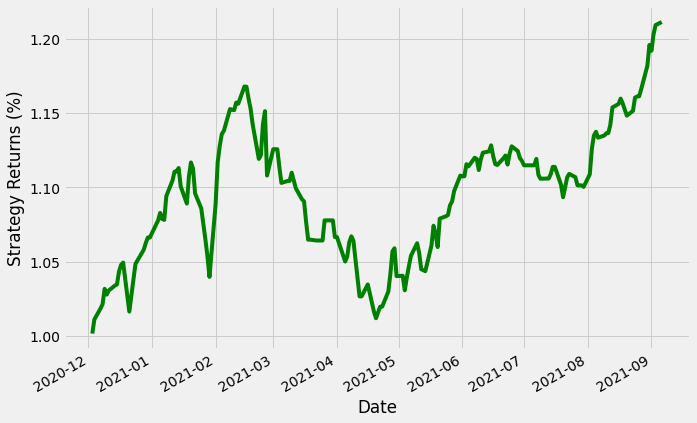

In [108]:
# Calculate daily returns
pred['Return'] = pred.Close.pct_change()

# Calculate strategy returns
pred['Strategy_F'] = pred.Return * pred.signalF.shift(1)

# Calculate geometric returns
geometric_returns = (pred.Strategy_F+1).cumprod()

# Plot geometric returns
geometric_returns.plot(figsize=(10, 7),color='g')
plt.ylabel("Strategy Returns (%)")
plt.xlabel("Date")
plt.show()